In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [4]:
import spacy
from spacy import displacy

In [6]:
df = pd.read_csv('data/articles.csv', index_col='index') #parser.py uses BeautifulSoup to make a clean .csv from html files
df.date = pd.to_datetime(df.date)

BrainPickings.org has 5000+ articles containing 5 million words. The author is interested in the evolving themes in her work. While this can be visualized with a stacked barchart (years on x, count on y, stacking is based on tags), I want to turn this into an NLP problem involving vectorization of the articles and then classification. The classification can be done in two ways: time and tags. Time would predict Early (written before 2014) or Late (written 2014-present) while tags would divide articles by popular tags and then try to guess which tag the article is filed under. Tags should be different, like Science an Art, two popular ones. In order to use rarer tags, you will have to undersample the more popular class 

Classifying articles into one of many tage is a multi-label problem. You'll want to calculate probabilities for each tag for every document. When making the model, think about the target and how to best transform the "natural language" into a vector that captures the essence of the target. Suppose you want to classify an article as being about Art or Science. A basic model would be to look for the words "art" and "science" in the article and return a vector of the counts. So if an article says "art" once and "science" three times th vector is [1,3]. You want the simplest representation of the article that gives the clearest signal of what the classification should be.

If the classification is about whether the author wrote the article early in their career or later, then you'll want to represent the article as a different vector. Maybe the inexperinced writer used a lot of curse words or said "like" to much. Maybe the stronger writer writes longer sentences or uses a wider vocabulary. In this case, using too small a vocabulary will not be a good idea. You want to represent the early articles as sparser with more reliance on commoner words. 

In choosing the right vector to capture the right signal, you'll want to think about the particular problem. Do you need rare words, do you need to filter out words that occur in most articles, do you need stems or lemmas, do you need puncutation, do you want a few stop words or many? Be careful as well you don't make a useless model. Suppose you left t4he date in the article and the model just used that to predict when it was written. Or maybe the author always signed off with a phrase and then stopped doing it, so the model just sees that.

Topic modeling is the process of discovering salient feautures in a corpus in an unsupervied way. 

### 1.1 Make classes based on date
The reason for doing this classification may be to distinguish Maria's early and late writing style.

In [10]:
#Summer (June 21) 2014 is my dividing line
#This date divides the total word count more or less evenly.
df["early"] = 1
df.early[(df.date > '2014-06-20')] = 0

In [11]:
#to remedy the class imbalance I'm gonna drop a lot of stub articles (under 280 words in this case)
early, late = df.early.value_counts()[1], df.early.value_counts()[0]
early_stubs = np.argsort(df.words[df.early==1].values)[:early-late]
early_stubs += 1 #original index started at 1! oops
df2=df.drop(index=early_stubs) #balanced classes
df2=df2.reset_index(drop=True)

In [12]:
#the corpus includes all articles including titles
documents = df2.title + df2.content

In [13]:
#cleaning
documents = documents.str.lower()
documents = documents.str.replace(',','') # this keeps numbers together
documents = documents.str.replace('[^\w\s]',' ') # apostrophes divide a word, which works with nltk.stopwords

### 1.2 Feature Extraction with Tf-Idf vectorizer

In [105]:
TFIDF = TfidfVectorizer(strip_accents="unicode",
                             min_df=75, #this makes like 3 fewer errors than the 25000 vocab model
                             max_df=.75,
                             stop_words='english') #ngram_range=(1,2)
X = TFIDF.fit_transform(documents)
X

<4570x4562 sparse matrix of type '<class 'numpy.float64'>'
	with 1159799 stored elements in Compressed Sparse Row format>

In [112]:
vocab = np.array(list(TFIDF.vocabulary_.keys()))
print(vocab)

['invisible' 'ad' 'art' ... '2015' 'vitalizing' 'largehearted']


In [107]:
X = StandardScaler().fit_transform(X.todense())
y = df2.early

### 1.3 Modeling

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=36)

#### 1.3.1 Logistic regression

In [109]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
preds = lr.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       457
           1       0.90      0.92      0.91       457

    accuracy                           0.91       914
   macro avg       0.91      0.91      0.91       914
weighted avg       0.91      0.91      0.91       914



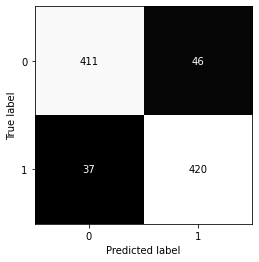

In [110]:
#already good
print(classification_report(y_test, preds))
plot_confusion_matrix(lr, X_test, y_test, cmap="gray", colorbar=False);

In [113]:
np.array(y_test)[:10]

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1])

In [114]:
preds[:10]

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 1])

In [116]:
errors = np.where(np.array(y_test) != preds)[0]
errors

array([  1,   5,  22,  33,  35,  45,  50,  51,  71,  77,  89, 106, 107,
       124, 133, 144, 147, 153, 158, 164, 167, 175, 177, 181, 188, 208,
       210, 212, 226, 227, 228, 230, 234, 241, 242, 278, 280, 282, 283,
       316, 318, 348, 361, 385, 388, 389, 414, 429, 445, 477, 486, 491,
       534, 540, 553, 554, 579, 586, 590, 618, 637, 641, 662, 664, 670,
       676, 685, 721, 749, 773, 779, 798, 806, 811, 818, 821, 825, 832,
       849, 855, 875, 892, 894])

In [129]:
X_errors = X_test[errors]
X_errors[9]

array([-0.26305973, -0.19634875, -0.10373406, ..., -0.12513574,
       -0.11772781, -0.09012969])

In [130]:
errors_ix=[]
#this finally worked, phew
for ix, x1 in enumerate(X):
    for x2 in X_errors:
        if np.array_equal(x1,x2):
            errors_ix.append(ix)

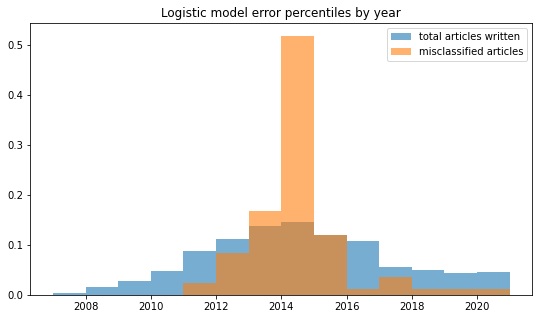

In [193]:
#yeah! errorframe
error_df = df2.iloc[errors_ix]

f,ax = plt.subplots(figsize=(9,5))
ax.hist(df2.date.dt.year, alpha=.6, density=True, bins=14, label="total articles written")
ax.hist(error_df.date.dt.year, alpha=.6, density=True, bins=10, label="misclassified articles")
ax.set_title("Logistic model error percentiles by year")
ax.legend();

Had this result been anything else, I'd suspect foul play. The model is right 91 percent of the time almost out-of-the-box. I divided the corpus in half rather arbitrarily. Nothing changed suddenly to make Popova a different writer (that I know of.) Writing styles change gradually and the model appears to truly be capturing this shift very well. (Had there been no spike in the 2014 transistion, I would assume the model had found a way to fit to the date secretly coded somewhere in the text and then I would reach out to Dan Brown to decode the hidden symbology.)

#### 1.3.2 Random forest

In [146]:
rf = RandomForestClassifier(n_estimators=500,
                            max_depth=12)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, n_estimators=500)

0.8916849015317286


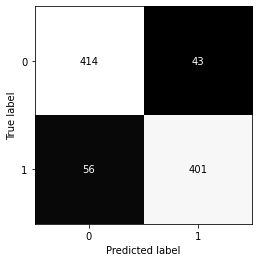

In [150]:
print(rf.score(X_test, y_test))
plot_confusion_matrix(rf, X_test, y_test, cmap="gray", colorbar=False);

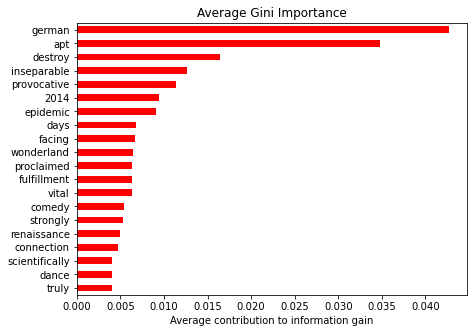

In [148]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=vocabulary)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', 
                      figsize=(7,5),
                      color='r')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [145]:
#### 1.3.2 Naive Bayes

## Spacy Classifier: Early/Late

In [ ]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

### 2. A multi-label problem
#### Make classes based on tags

In [ ]:
art, science, love, poetry, cinema, philosophy, psychology  = [],[],[],[],[],[],[]

for ix, tag in enumerate(df.tags):
    if re.match(".* art,.*", tag) or re.match("art,.*", tag): art.append(ix)

for ix, tag in enumerate(df.tags):
    if re.match(".*science,.*", tag): science.append(ix)

In [ ]:
art_df=df.iloc[art]
art_df["art"]=1

sci_df=df.iloc[science]
sci_df["art"]=0

df2 = pd.concat([art_df, sci_df])

# ~250 articles are duplicates, tagged both art and science
# I remove them but is it a multi-label problem?
df2=df2[df2.index.value_counts()==1]
df2=df2.reset_index(drop=True)

### Science/art tag classes

In [ ]:
y = df2.art
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2,
                                                    stratify=y, random_state=36)

In [ ]:
X_train.shape

In [ ]:
#oversample science class
X_train, y_train = SMOTE().fit_resample(X_train, y_train.ravel())

In [ ]:
X_train.shape

### Logistic regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
preds = lr.predict(X_test)

In [ ]:
print(classification_report(y_test, preds))

In [ ]:
plot_confusion_matrix(lr, X_test, y_test);

### EXTRA: Spacy

In [ ]:
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_md") #or sm

In [ ]:
# Process whole documents
doc = nlp(df.content[1111])

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)
    
sentence_spans = list(doc.sents)

In [ ]:
displacy.serve(sentence_spans[3], style="ent")

In [ ]:
displacy.serve(sentence_spans[3], style="dep", options={"compact":True, "color":"#FFFFFF", "bg":"#448ee4"})

### NMF (unsupervised)

In [ ]:
nmf = NMF(n_components=4, max_iter=400)
nmf.fit(X)

In [ ]:
H = nmf.components_
H.shape

In [ ]:
for i, row in enumerate(H):
    top = np.argsort(row)[::-1][:15]
    print(i, ', '.join(vocabulary[top]))

### Stop the presses, random forest 90 percent accurate tag classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15)
rf.fit(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)
plot_confusion_matrix(rf, X_test, y_test);

In [ ]:
plot_confusion_matrix(rf, X_test, y_test);

In [ ]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=vocabulary)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', 
                      figsize=(7,5),
                      color='r')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500,
                                 learning_rate=0.05,
                                 max_depth=20, random_state=36).fit(X_train, y_train)
clf.score(X_test, y_test)